In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

# Import Data

In [2]:
sample_df = pd.read_csv('./data.csv')

# EDA

| Column                         | Description                                                                 |
|--------------------------------|-----------------------------------------------------------------------------|
| Date received                  | The date when the consumer's complaint was received.                        |
| Product                        | The specific financial product or service related to the complaint.         |
| Sub-product                    | A more detailed sub-category of the product or service.                     |
| Issue                          | The main problem described in the consumer's complaint.                     |
| Sub-issue                      | Additional details or sub-category related to the main issue.               |
| Consumer complaint narrative   | A text description provided by the consumer detailing their complaint.      |
| Company public response        | The response or statement issued by the company regarding the complaint.    |
| Company                        | The name of the company being complained about.                              |
| State                          | The state of residence of the consumer.                                     |
| ZIP code                       | The postal code of the consumer's location.                                 |
| Tags                           | Additional tags or labels related to the complaint.                         |
| Consumer consent provided?     | Indicates whether the consumer consented to publish their complaint.        |
| Submitted via                  | The channel or method used to submit the complaint.                         |
| Date sent to company           | The date when the complaint was forwarded to the company for response.      |
| Company response to consumer   | The response or resolution from the company to the consumer's complaint.    |
| Timely response?               | Indicates whether the company responded in a timely manner.                 |
| Consumer disputed?             | Indicates whether the consumer disputed the company's response.             |
| Complaint ID                   | A unique identifier assigned to each complaint.                             |

In [3]:
sample_df.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,XXXX is in violation of. 15 usc 1681 section 6...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NY,112XX,NaN,Consent provided,Web,2023-01-01,Closed with non-monetary relief,Yes,NaN,6384775
1,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,Address 's does not belong to me XXXX XXXX XXX...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,NC,28262,NaN,Consent provided,Web,2023-01-01,Closed with non-monetary relief,Yes,NaN,6384724
2,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days,The credit reporting agency is reporting infor...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,OH,431XX,NaN,Consent provided,Web,2023-01-01,Closed with non-monetary relief,Yes,NaN,6384896
3,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",MO,63366,NaN,Consent not provided,Web,2023-01-01,Closed with non-monetary relief,Yes,NaN,6382439
4,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,XXXX is in violation of The XXXX XXXX that req...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,MO,655XX,Servicemember,Consent provided,Web,2023-01-01,Closed with explanation,Yes,NaN,6383627


In [4]:
sample_df.shape

(399046, 18)

In [5]:
# Formating Columns Name
sample_df.columns = (
    sample_df.columns
    .str.strip()
    .str.lower()
    .str.replace(r'\s+', '_', regex=True)
    .str.replace(r'[^\w]', '', regex=True)
)

sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399046 entries, 0 to 399045
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   date_received                 399046 non-null  object 
 1   product                       399046 non-null  object 
 2   subproduct                    399045 non-null  object 
 3   issue                         399045 non-null  object 
 4   subissue                      385096 non-null  object 
 5   consumer_complaint_narrative  239524 non-null  object 
 6   company_public_response       226285 non-null  object 
 7   company                       399046 non-null  object 
 8   state                         397871 non-null  object 
 9   zip_code                      399040 non-null  object 
 10  tags                          24390 non-null   object 
 11  consumer_consent_provided     381808 non-null  object 
 12  submitted_via                 399046 non-nul

In [6]:
# Convert date columns to datetime format
date_cols = ['date_received', 'date_sent_to_company']
sample_df[date_cols] = sample_df[date_cols].apply(pd.to_datetime, errors='coerce')

# Extract day, month, and year components from each date column
for col in date_cols:
    sample_df[f'{col}_day'] = sample_df[col].dt.day
    sample_df[f'{col}_month'] = sample_df[col].dt.month
    sample_df[f'{col}_year'] = sample_df[col].dt.year

# Calculate the number of days taken to forward the complaint to the company
# (difference between 'date_sent_to_company' and 'date_received')
sample_df['processing_day'] = (sample_df['date_sent_to_company'] - sample_df['date_received']).dt.days

# Display the first few rows of the updated DataFrame
sample_df.head()

,date_received,product,subproduct,issue,subissue,consumer_complaint_narrative,company_public_response,company,state,zip_code,...,timely_response,consumer_disputed,complaint_id,date_received_day,date_received_month,date_received_year,date_sent_to_company_day,date_sent_to_company_month,date_sent_to_company_year,processing_day
0,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,XXXX is in violation of. 15 usc 1681 section 6...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",NY,112XX,...,Yes,NaN,6384775,1,1,2023,1,1,2023,0
1,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Credit inquiries on your report that you don't...,Address 's does not belong to me XXXX XXXX XXX...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,NC,28262,...,Yes,NaN,6384724,1,1,2023,1,1,2023,0
2,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days,The credit reporting agency is reporting infor...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,OH,431XX,...,Yes,NaN,6384896,1,1,2023,1,1,2023,0
3,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,NaN,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",MO,63366,...,Yes,NaN,6382439,1,1,2023,1,1,2023,0
4,2023-01-01,"Credit reporting, credit repair services, or o...",Credit reporting,Improper use of your report,Reporting company used your report improperly,XXXX is in violation of The XXXX XXXX that req...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,MO,655XX,...,Yes,NaN,6383627,1,1,2023,1,1,2023,0


## Product Column

In [7]:
list(sample_df['product'].unique())

['Credit reporting, credit repair services, or other personal consumer reports',
 'Vehicle loan or lease',
 'Credit card or prepaid card',
 'Student loan',
 'Debt collection',
 'Checking or savings account',
 'Money transfer, virtual currency, or money service',
 'Mortgage',
 'Payday loan, title loan, or personal loan',
 'Credit reporting or other personal consumer reports',
 'Credit card',
 'Prepaid card',
 'Payday loan, title loan, personal loan, or advance loan',
 'Debt or credit management']

**Insight from unique values in the product column**

1. Some products are actually the same but have different phrasing → category normalization is necessary to ensure consistency and avoid bias in calculations or models.

2. Categories that can be combined into **Credit reporting**
- 'Credit reporting, credit repair services, or other personal consumer reports'
- 'Credit reporting or other personal consumer reports'

    (Both have the same core: credit reporting services and consumer reports.)

3. Categories that can be combined into **Credit card / Prepaid card**
- 'Credit card or prepaid card'
- 'Credit card'
- 'Prepaid card'

    (All three relate to credit card or prepaid card services, the only difference being the type of card.)

3. Categories that can be combined into **Payday/Title/Personal loan**
- 'Payday loan, title loan, or personal loan'
- 'Payday loan, title loan, personal loan, or advance loan'

    (Both cover payday, title, personal, and advance loans — essentially the same thing.)

In [8]:
mapping = {
    'Credit reporting, credit repair services, or other personal consumer reports': 'Credit reporting',
    'Credit reporting or other personal consumer reports': 'Credit reporting',
    'Credit card or prepaid card': 'Credit card / Prepaid card',
    'Credit card': 'Credit card / Prepaid card',
    'Prepaid card': 'Credit card / Prepaid card',
    'Payday loan, title loan, or personal loan': 'Payday/Title/Personal loan',
    'Payday loan, title loan, personal loan, or advance loan': 'Payday/Title/Personal loan'
}

sample_df['product_clean'] = sample_df['product'].replace(mapping)

In [9]:
# Count the number of data per category
count_per_category = sample_df['product_clean'].value_counts()

# Calculate the percentage per category
percentage_per_category = sample_df['product_clean'].value_counts(normalize=True) * 100

# Combine into one table
summary = pd.DataFrame({
    'count': count_per_category,
    'percentage': percentage_per_category
})

summary

,count,percentage
product_clean,,
Credit reporting,320496,80.315553
Debt collection,25599,6.415050
Credit card / Prepaid card,16502,4.135363
Checking or savings account,13762,3.448725
"Money transfer, virtual currency, or money service",8038,2.014304
Mortgage,5551,1.391068
Student loan,3333,0.835242
Vehicle loan or lease,3297,0.826221
Payday/Title/Personal loan,2093,0.524501


**Insight from unique values in the product_clean column**

1. Categories with a proportion of <1% should be combined to be more generic and reduce class imbalance.
2. Debt collection and Debt or credit management are combined into a single category called Debt-related because they share similar topics.
3. Student loans, Vehicle loans or leases, and Payday/Title/Personal loans are combined into the Other category because they are small in number and lack strong ties to other major categories.

In [10]:
def group_products(product):
    if product == 'Credit reporting':
        return 'Credit reporting'
    elif product == 'Credit card / Prepaid card':
        return 'Credit/Prepaid card'
    elif product in ['Debt collection', 'Debt or credit management']:
        return 'Debt related'
    elif product == 'Checking or savings account':
        return 'Checking/Savings account'
    elif product == 'Money transfer, virtual currency, or money service':
        return 'Money services'
    elif product == 'Mortgage':
        return 'Mortgage'
    else:
        return 'Other'  # Student loan, Vehicle loan/lease, Payday/Title/Personal loan  

sample_df['product_group'] = sample_df['product_clean'].apply(group_products)

# Count the number of data per category
count_per_category = sample_df['product_group'].value_counts()

# Calculate the percentage per category
percentage_per_category = sample_df['product_group'].value_counts(normalize=True) * 100

# Combine into one table
summary = pd.DataFrame({
    'count': count_per_category,
    'percentage': percentage_per_category
})

summary

,count,percentage
product_group,,
Credit reporting,320496,80.315553
Debt related,25974,6.509024
Credit/Prepaid card,16502,4.135363
Checking/Savings account,13762,3.448725
Other,8723,2.185964
Money services,8038,2.014304
Mortgage,5551,1.391068


## State Column

In [11]:
# Create a DataFrame from value_counts
state_counts = (
    sample_df['state']
    .value_counts(dropna=False)
    .reset_index()
)

# Change the column name
state_counts.columns = ['State', 'Count']

# Add percentage column
state_counts['Percentage'] = (state_counts['Count'] / len(sample_df) * 100).round(2)

# Display unique list in one column and their count
display(state_counts)

# Display unique list
print("Unique state values:")
print(state_counts['State'].tolist())

,State,Count,Percentage
0,FL,53300,13.36
1,TX,51771,12.97
2,CA,39686,9.95
3,GA,30413,7.62
4,NY,24667,6.18
...,...,...,...
56,AP,28,0.01
57,GU,15,0.00
58,MP,4,0.00
59,AA,4,0.00


Unique state values:
['FL', 'TX', 'CA', 'GA', 'NY', 'IL', 'PA', 'NC', 'NJ', 'MD', 'MI', 'VA', 'OH', 'LA', 'SC', 'AL', 'AZ', 'TN', 'NV', 'IN', 'MO', 'MA', 'MS', 'CT', 'WA', 'WI', 'CO', 'AR', 'MN', 'DE', 'KY', 'OK', 'DC', 'OR', 'UT', nan, 'PR', 'KS', 'NE', 'IA', 'NM', 'RI', 'HI', 'WV', 'ID', 'NH', 'ME', 'ND', 'MT', 'AK', 'WY', 'SD', 'VT', 'VI', 'AE', 'UNITED STATES MINOR OUTLYING ISLANDS', 'AP', 'GU', 'MP', 'AA', 'AS']


**Insights from state Column Unique Values**

Based on the unique values in the state column, several data quality issues were identified that led to the decision to normalize this column:

1. **Mixed formats** – Most values are already in US two-letter state codes (e.g., NY, CA), but there are exceptions such as "UNITED STATES MINOR OUTLYING ISLANDS" which uses a full name.
2. **Missing values** – Some entries are NaN and need to be handled consistently.
3. **Non-mainland US territories** – Values like PR (Puerto Rico), GU (Guam), VI (Virgin Islands), MP (Northern Mariana Islands), and AS (American Samoa) are US territories, not states.
4. **Military postal codes** – Values like AE, AP, and AA indicate military addresses rather than standard US states.
5. **Potential redundancy with ZIP code** – Since ZIP codes inherently contain location information, state should still be standardized to avoid mismatches when combining with ZIP codes.
6. **Inconsistent representation** – Some values represent the same location in different formats (e.g., "UNITED STATES MINOR OUTLYING ISLANDS" vs UM).

---

**State Column Normalization Process**

The normalization process applied to the state column included the following steps:

1. **Uppercasing and trimming whitespace**  
   Ensure all values are in uppercase and free from leading/trailing spaces for consistency.

2. **Mapping full names to official codes**  
   Convert "UNITED STATES MINOR OUTLYING ISLANDS" to its ISO 3166-2 code "UM".

3. **Handling missing values**  
   Replace NaN with "Unknown" to maintain a consistent placeholder for missing data.

4. **Classifying state types**  
   - "State" → Standard US states and District of Columbia.  
   - "Territory" → US territories such as PR, GU, VI, MP, AS, and UM.  
   - "Military" → Military postal codes AE, AP, and AA.  
   - "Unknown" → Missing or unrecognized entries.

5. **Adding regional grouping** (optional)  
   Assign each state to one of the US Census Bureau regions:
   - **Northeast**: CT, ME, MA, NH, RI, VT, NJ, NY, PA  
   - **Midwest**: IL, IN, MI, OH, WI, IA, KS, MN, MO, NE, ND, SD  
   - **South**: DE, FL, GA, MD, NC, SC, VA, DC, WV, AL, KY, MS, TN, AR, LA, OK, TX  
   - **West**: AZ, CO, ID, MT, NV, NM, UT, WY, AK, CA, HI, OR, WA  
   - **Territory**: PR, GU, VI, MP, AS, UM  
   - **Military**: AE, AP, AA  
   - **Unknown**: Missing values

By applying this normalization, the state column becomes consistent, analysis-ready, and suitable for grouping, visualization, and feature engineering.


In [12]:
states = [
    'NY','NC','OH','MO','MA','VA','TX','GA','TN','CA','FL','PA','MS','IN','LA','NV','MD','MI','WI',
    'AZ','IL','AL','CO','NJ','WA','MN','DC','CT','AR','PR','SC','UT','NM','DE','KY','OR','RI','KS',
    'OK','ID','NE','WY','WV','ME','NH','MT',np.nan,'HI','VT','AK','ND','IA','UNITED STATES MINOR OUTLYING ISLANDS',
    'SD','AE','MP','GU','AP','VI','AA','AS'
]

# Mapping long name → code
name_to_code = {
    'UNITED STATES MINOR OUTLYING ISLANDS': 'UM'
}

# Special categories
territories = ['PR', 'GU', 'VI', 'MP', 'AS', 'UM']
military = ['AE', 'AP', 'AA']

# Region US Census Bureau
northeast = ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA']
midwest = ['IL', 'IN', 'MI', 'OH', 'WI', 'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD']
south = ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'DC', 'WV', 'AL', 'KY', 'MS', 'TN', 'AR', 'LA', 'OK', 'TX']
west = ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY', 'AK', 'CA', 'HI', 'OR', 'WA']

# Mapping function
def normalize_state(val):
    if pd.isna(val):
        return 'Unknown'
    val = val.strip().upper()
    if val in name_to_code:
        return name_to_code[val]
    return val

def map_group(code):
    if code == 'Unknown':
        return 'Unknown'
    elif code in territories:
        return 'Territory'
    elif code in military:
        return 'Military'
    else:
        return 'State'

def map_region(code):
    if code in northeast: return 'Northeast'
    elif code in midwest: return 'Midwest'
    elif code in south: return 'South'
    elif code in west: return 'West'
    elif code in territories: return 'Territory'
    elif code in military: return 'Military'
    elif code == 'Unknown': return 'Unknown'
    else: return 'Other'

# Apply mapping
sample_df['state_clean'] = sample_df['state'].apply(normalize_state)
sample_df['state_group'] = sample_df['state_clean'].apply(map_group)
sample_df['region'] = sample_df['state_clean'].apply(map_region)

In [13]:
sample_df[['state', 'state_clean', 'state_group', 'region']].head()

,state,state_clean,state_group,region
0,NY,NY,State,Northeast
1,NC,NC,State,South
2,OH,OH,State,Midwest
3,MO,MO,State,Midwest
4,MO,MO,State,Midwest


## Analysis of the time the complaint was received by the CFPB and the time the complaint was sent to the company

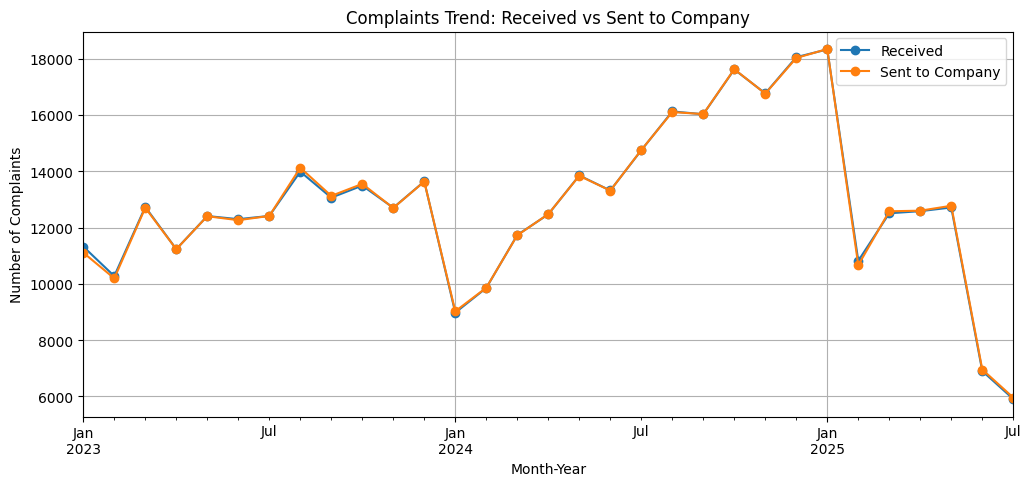

In [15]:
# Number of complaints per month/year for date_received
complaints_received = sample_df.groupby(sample_df['date_received'].dt.to_period('M')).size()

# Number of complaints per month/year for date_sent_to_company
complaints_sent = sample_df.groupby(sample_df['date_sent_to_company'].dt.to_period('M')).size()

# Compare the trends of both in one chart
trend_df = pd.DataFrame({
    'Received': complaints_received,
    'Sent to Company': complaints_sent
})

trend_df.plot(kind='line', marker='o', figsize=(12, 5))
plt.title('Complaints Trend: Received vs Sent to Company')
plt.xlabel('Month-Year')
plt.ylabel('Number of Complaints')
plt.legend()
plt.grid(True)
plt.show()

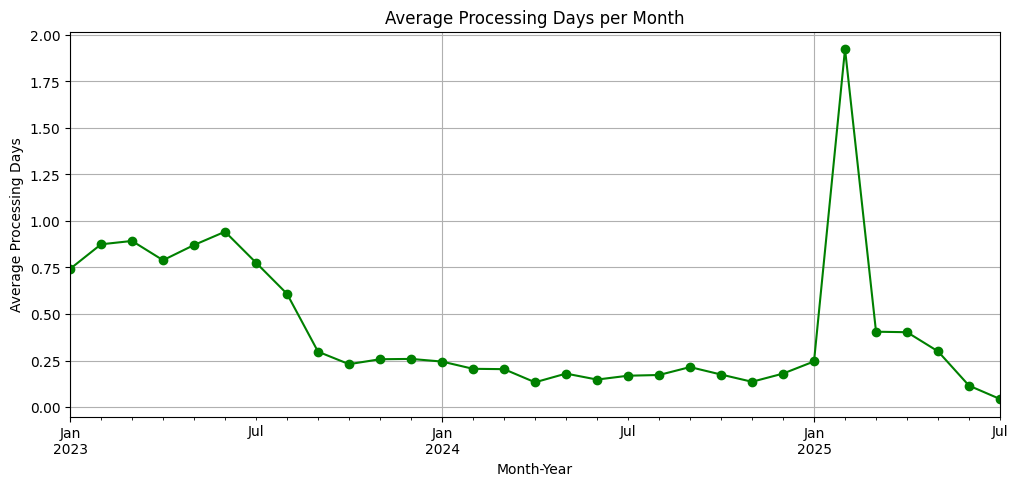

In [16]:
# Average trend of processing_days per month/year

avg_processing = sample_df.groupby(sample_df['date_received'].dt.to_period('M'))['processing_day'].mean()

avg_processing.plot(kind='line', marker='o', figsize=(12, 5), color='green')
plt.title('Average Processing Days per Month')
plt.xlabel('Month-Year')
plt.ylabel('Average Processing Days')
plt.grid(True)
plt.show()